In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy
from stable_baselines3.common.utils import get_linear_fn, LinearSchedule

from typing import Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt

from pettingzoo.utils import ParallelEnv
import functools

from __future__ import annotations
import glob
import os

import supersuit as ss



# vs static opp., 1-period

In [4]:
def optimal_linear_kyle(sigma_u, mean_v, sigma_v):
    beta = math.sqrt(sigma_u ** 2 / sigma_v)  # Insider's coefficient
    lambda_ = 0.5 * math.sqrt(sigma_v / (sigma_u ** 2))  # MM's coefficient
    return beta, lambda_

def optimal_insider_x(v, sigma_u, mean_v, sigma_v):
    beta, _ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)

    return beta * (v - mean_v)

def set_linear_price(y, sigma_v, sigma_u, mean_v):
    beta, lambda_ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)
    return mean_v + lambda_ * y

## RL Insider vs static MM

In [ ]:
class KyleModelEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnv, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.observation_space = spaces.Dict({
            'v': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        })

        self.reset()

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.v = np.random.normal(self.p0, self.sigma_v)  # True asset value
        self.p = self.p0
        self.t = 0

        obs = self._get_insider_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_insider_obs(self):
        return {
            'v': np.array([self.v], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        scaled_action = action * 10
        self.actual_actions.append(scaled_action[0])

        x = scaled_action[0]
        u = np.random.normal(0, self.sigma_u)
        y = x + u
        lambda_kyle = 0.5 * math.sqrt(self.sigma_v / (self.sigma_u ** 2))
        p_new = self.p + lambda_kyle * y

        insider_profit = (self.v - p_new) * x

        # Update state
        self.p = p_new
        self.t += 1

        terminated = (self.t >= self.T)  # natural end
        truncated = False  # No time/truncation logic here

        obs = self._get_insider_obs()
        info = {}

        return obs, insider_profit, terminated, truncated, info



# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_insider = KyleModelEnv()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64]
)

model_insider = PPO(
    "MultiInputPolicy",  
    env_insider,
    verbose = 0,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_insider.learn(total_timesteps=55_000)
model_insider.save("ppo_mm")

# Test trained agent
obs = env_insider.reset()
obs = env_insider.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/Paul/miniforge3/envs/tradingrl/lib/python3.13/site-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -28.9    |
| time/              |          |
|    fps             | 5019     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -18.9      |
| time/                   |            |
|    fps                  | 3337       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.07603786 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.296      |
|    entropy_loss         | -1.29      |
|    explained_variance   | 1.57e-05   |
|    learning_rate        | 0.001      |
|   

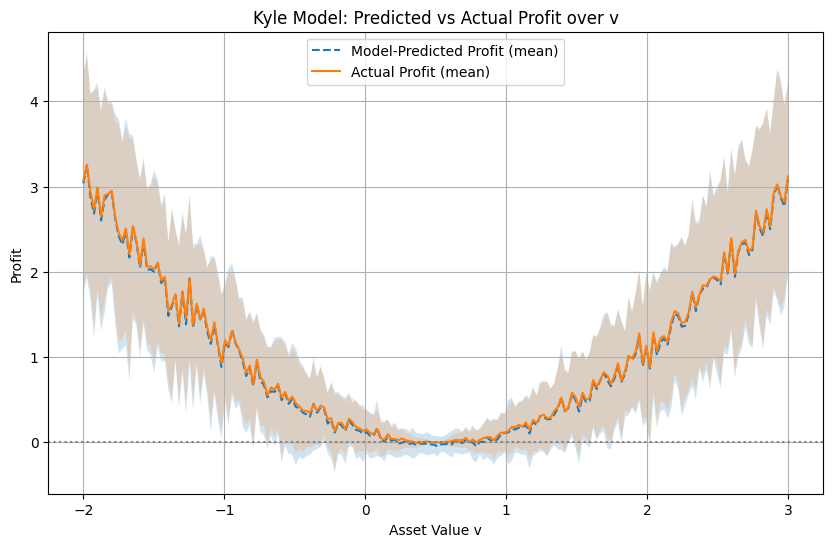

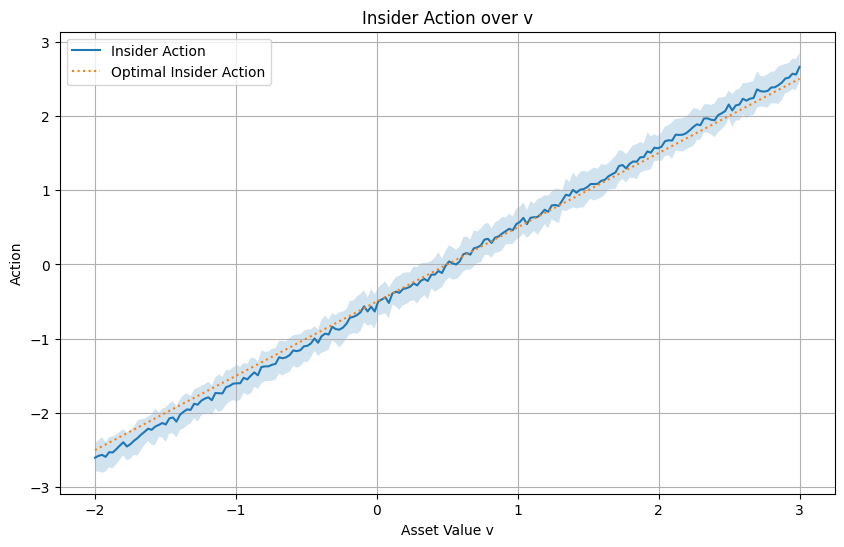

In [ ]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))
    scaled_actions = np.zeros((num_trials, num_points))
    


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs['v'][0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u
            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)

            action, _ = model.predict(obs, deterministic=True)
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 10  # scale to actual action

            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u
            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit
            scaled_actions[j][i] = x
            # print(f"Opt.: {actual_x:.3f}, Insider: {x:.3f}")


    return predicted_profits, actual_profits, scaled_actions


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_actions_insider(values, actions, env):
    mean_actions = actions.mean(axis=0)
    std_actions = actions.std(axis=0)
    optimal_actions = optimal_insider_x(values, env.sigma_u, env.p0, env.sigma_v)
    plt.figure(figsize=(10, 6))
    plt.plot(values, mean_actions, label="Insider Action", linestyle='-')
    plt.fill_between(values, mean_actions - std_actions, mean_actions + std_actions, alpha=0.2)
    plt.plot(values, optimal_actions, label="Optimal Insider Action", linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Action")
    plt.title("Insider Action over v")
    plt.legend()
    plt.grid(True)
    plt.show()




start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual, scaled_actions = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std, actual_mean, actual_std)
plot_actions_insider(values, scaled_actions, env_insider)

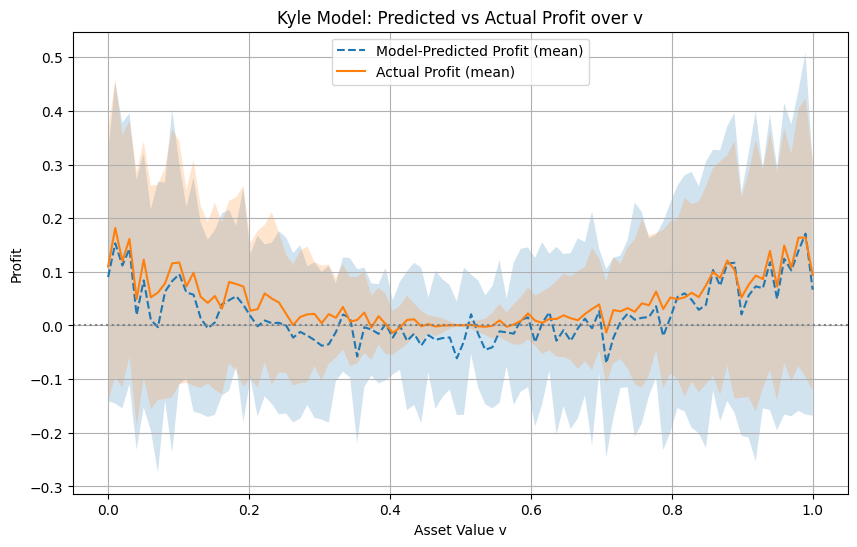

In [ ]:
start_point = 0
end_point = 1
num_points = 100
num_trials = 50
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points = 100)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


In [12]:

class KyleModelEnvMM(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnvMM, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        self.beta_kyle, _ = optimal_linear_kyle(self.sigma_u, self.p0, self.sigma_v)

        # Define action space (Market Maker's price guess)
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Observation space for the market maker
        self.observation_space = spaces.Dict({
            'y': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'p0': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_v': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_u': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

    def reset(self, *, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        # True asset value is drawn from N(p0, sigma_v^2)
        self.v = np.random.normal(self.p0, self.sigma_v)

        # Initialize state variables
        self.p = self.p0
        self.t = 0

        # Generate initial observation
        self.x = self.beta_kyle * (self.v - self.p0)
        u = np.random.normal(0, self.sigma_u)
        self.y = self.x + u

        obs = self._get_mm_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_mm_obs(self) -> Dict[str, np.ndarray]:
        return {
            'y': np.array([self.y], dtype=np.float32),
            'p0': np.array([self.p], dtype=np.float32),
            'sigma_v': np.array([self.sigma_v], dtype=np.float32),
            'sigma_u': np.array([self.sigma_u], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step of the environment"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        # Scale PPO's normalized action to market price guess
        scaled_action = action[0] * 10
        self.actual_actions.append(scaled_action)

        # Market maker's loss function (negative MSE against true value)
        mm_loss = -((scaled_action - self.v) ** 2)

        # Update timestep
        self.t += 1

        terminated = (self.t >= self.T)  # natural termination
        truncated = False  # no time truncation here

        obs = self._get_mm_obs()
        info = {}

        return obs, mm_loss, terminated, truncated, info







# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_mm = KyleModelEnvMM()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64,64]
)

model_mm = PPO(
    "MultiInputPolicy",
    env_mm,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_mm.learn(total_timesteps=75_000)
model_mm.save("ppo_mm")

# Test trained agent
obs = env_mm.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/Paul/miniforge3/envs/tradingrl/lib/python3.13/site-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -45.8    |
| time/              |          |
|    fps             | 4303     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -35.9       |
| time/                   |             |
|    fps                  | 2599        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.084461436 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.297       |
|    entropy_loss         | -1.28       |
|    explained_variance   | -0.000288   |
|    learning_rate        | 0.

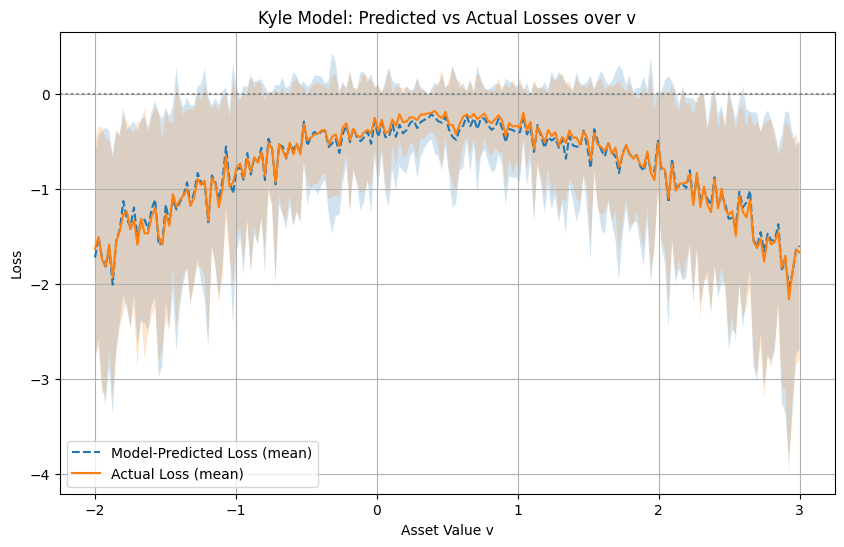

In [ ]:
def evaluate_losses(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_trials, num_points))
    actual_losses = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        env.v = v

        for j in range(num_trials):

            #  and sample u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)
            x = beta_kyle * (v - env.p0)


            y = x + u
            obs['y'] = np.array([y], dtype=np.float32)

            # Scale PPO's normalized action to market order size
            action, _ = model.predict(obs)
            scaled_action = action[0] * 10  # scale to actual action




            kyle_price = env.p0 + lambda_kyle * y

            predicted_loss = - ((scaled_action - v) ** 2)
            actual_loss = - ((v - kyle_price) ** 2)

            predicted_losses[j][i] = predicted_loss
            actual_losses[j][i] = actual_loss
            if actual_loss > 20:
                print(f"beta kyle : {beta_kyle}")
                print(f"lambda kyle : {lambda_kyle}")
                print(f"predicted loss : {predicted_loss}")
                print(f"actual loss : {actual_loss}")
                print(f"scaled action : {scaled_action}")
                print(f"kyle price : {kyle_price}")
                print(f"x : {x}")
                print(f"y : {y}")
                print(f"u : {u}")
                print(f"v : {v}")


    return predicted_losses, actual_losses


def plot_losses(predicted_losses, actual_losses, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Loss (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Loss (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Loss")
    plt.title("Kyle Model: Predicted vs Actual Losses over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_losses(env_mm, start_point, end_point, model_mm, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_losses(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




# MARL, one-period

## Definitions

**Note:** to have the insider learn properly against a fixed opponent, you can uncomment the line inside `step()` that overrides the market maker's action with the optimal action.

otherwise, even if you have an optimal market maker agent (the `OptimalMM` class I define below), it won't work -- that one will always output the optimal action for the static observation `obs = env.reset() = [p0, sigma_v, sigma_u, 0]`.

In [ ]:
class KyleOnePeriodAEC(ParallelEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodParallel",
    }

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1):
        super().__init__()
        self.sigma_v = sigma_v  # std of value
        self.sigma_u = sigma_u  # std of noise
        self.p0 = p0  # mean of value
        self.timestep = 0
        self.gamma = gamma
        self.T = T  # time horizon (set to 1 for single period)

        self.possible_agents = ["insider", "market_maker"]
        self.render_mode = None  # add this line

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }


    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}

        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}

        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Sample true value
        self.v = np.random.normal(self.p0, self.sigma_v)
        self.u = np.random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos. Necessary for proper parallel_to_aec conversion
        infos = {a: {} for a in self.agents}

        return observations, infos

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v, self.sigma_u], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v, self.sigma_u, self.y], dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]


    def step(self, actions):
        # Default rewards
        rewards = {a: 0 for a in self.agents}

        # Only update actions for agents that actually have an action
        insider_action = actions["insider"][0]
        scaled_insider_action = insider_action * 10
        market_maker_action = actions["market_maker"][0]
        scaled_market_maker_action = market_maker_action * 10



        self.y = scaled_insider_action + self.u

        # # TESTING: MM optimal action
        # scaled_market_maker_action = get_optimal_market_maker_action(self.y, self.sigma_u, self.p0, self.sigma_v)

        insider_profit = (self.v - scaled_market_maker_action) * scaled_insider_action
        market_maker_loss = -(scaled_market_maker_action - self.v)*self.y

        if "insider" in self.agents:
            rewards["insider"] = insider_profit
        if "market_maker" in self.agents:
            rewards["market_maker"] = market_maker_loss

        self.rewards = rewards

        # Observations
        observations = {}
        if "insider" in self.agents:
            observations["insider"] = self.observe_insider()
        if "market_maker" in self.agents:
            observations["market_maker"] = self.observe_market_maker()

        infos = {a: {} for a in self.agents}

        # Increase timestep
        self.timestep += 1
        if self.timestep >= self.T:
            terminations = {a: True for a in ["insider", "market_maker"]}
            truncations = {a: True for a in ["insider", "market_maker"]}
        else:
            terminations = {a: False for a in ["insider", "market_maker"]}
            truncations = {a: False for a in ["insider", "market_maker"]}

        return observations, rewards, terminations, truncations, infos

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        insider_reward = self.rewards["insider"]
        print(f"Agents' rewards: {insider_reward}")




In [113]:
def get_linear_kyle_eq_params(sigma_u, mean_v, sigma_v):
    beta = sigma_u / sigma_v  # Insider's coefficient
    lambda_ = sigma_v / (2 * sigma_u)  # MM's coefficient
    return beta, lambda_

def get_optimal_insider_action(v, sigma_u, mean_v, sigma_v):
    beta, _ = get_linear_kyle_eq_params(sigma_u, mean_v, sigma_v)
    return beta * (v - mean_v)

def get_optimal_market_maker_action(y, sigma_u, mean_v, sigma_v):
    _, lambda_ = get_linear_kyle_eq_params(sigma_u, mean_v, sigma_v)
    return mean_v + lambda_ * y

In [117]:
def evaluate_agents(models, env, n_stdevs):
    I = models["insider"]
    MM = models["market_maker"]

    num_points = 100
    min_price = env.p0 - n_stdevs * env.sigma_v
    max_price = env.p0 + n_stdevs * env.sigma_v
    min_order = -n_stdevs*env.sigma_u
    max_order = n_stdevs*env.sigma_u

    values = np.linspace(min_price, max_price, num_points)
    orders = np.linspace(min_order, max_order, num_points)

    optimal_insider_actions = np.zeros((num_points))
    optimal_market_maker_actions = np.zeros((num_points))
    actual_insider_actions_raw = np.zeros((num_points))
    actual_insider_actions_scaled = np.zeros((num_points))
    actual_market_maker_actions_raw = np.zeros((num_points))
    actual_market_maker_actions_scaled = np.zeros((num_points))

    for i in range(len(values)):
        v = values[i]
        y = orders[i]

        obs_I = np.array([v, env.p0, env.sigma_v, env.sigma_u])
        obs_MM = np.array([env.p0, env.sigma_v, env.sigma_u, y])

        # Optimal actions
        optimal_insider_action = get_optimal_insider_action(v, env.sigma_u, env.p0, env.sigma_v)
        optimal_market_maker_action = get_optimal_market_maker_action(y, env.sigma_u, env.p0, env.sigma_v)
        optimal_insider_actions[i] = optimal_insider_action
        optimal_market_maker_actions[i] = optimal_market_maker_action

        # for j in range(n_seeds):
        # Predicted actions
        actual_insider_action, _ = I.predict(obs_I, deterministic=True)
        actual_market_maker_action, _ = MM.predict(obs_MM, deterministic=True)
        actual_insider_action_scaled = actual_insider_action[0] * 10
        actual_market_maker_action_scaled = actual_market_maker_action[0] * 10
        actual_insider_actions_raw[i] = actual_insider_action[0]
        actual_market_maker_actions_raw[i] = actual_market_maker_action[0]
        actual_insider_actions_scaled[i] = actual_insider_action_scaled
        actual_market_maker_actions_scaled[i] = actual_market_maker_action_scaled
    
    # plot: 2 subplots. one for insider (values vs action) and one for market maker (order vs action)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Insider subplot
    ax1.plot(values, optimal_insider_actions, label="Optimal", linestyle='--')
    ax1.plot(values, actual_insider_actions_scaled, label="Scaled", linestyle='-')
    ax1.plot(values, actual_insider_actions_raw, label="Raw", linestyle=':')
    ax1.set_title("Insider Action")
    ax1.set_xlabel("Value v")
    ax1.set_ylabel("Action x")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Market Maker subplot
    ax2.plot(orders, optimal_market_maker_actions, label="Optimal", linestyle='--')
    ax2.plot(orders, actual_market_maker_actions_scaled, label="Scaled", linestyle='-')
    ax2.plot(orders, actual_market_maker_actions_raw, label="Raw", linestyle=':')
    ax2.set_title("Market Maker Action")
    ax2.set_xlabel("Order y")
    ax2.set_ylabel("Price p")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [125]:
class OptimalMM:
    def __init__(self):
        self.env = None

    def from_env(cls, env):
        return cls(env.sigma_v, env.sigma_u, env.p0, env.gamma, env.T)
    
    def set_env(self, env):
        self.env = env
        return self
    
    def learn(self, total_timesteps, *args, **kwargs):
        print("OptimalMM: fixed, no learning")
        return self

    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        # Support dict or array obs. Your env gives MM obs = [p0, sigma_v^2, sigma_u^2, y]
        if isinstance(obs, dict):
            p0 = float(np.asarray(obs["p0"]).reshape(-1)[0])
            sigma_v = float(np.asarray(obs["sigma_v"]).reshape(-1)[0])
            sigma_u = float(np.asarray(obs["sigma_u"]).reshape(-1)[0])
            y = float(np.asarray(obs["y"]).reshape(-1)[0])
        else:
            o = np.asarray(obs, dtype=np.float32).reshape(-1)
            # obs = [p0, sigma_v^2, sigma_u^2, y]
            p0 = float(o[0])
            sigma_v = float(o[1])
            sigma_u = float(o[2])
            y = float(o[3])

        # Optimal MM price p* = p0 + λ y, where λ = sigma_v / (2 * sigma_u)
        p_star = get_optimal_market_maker_action(y, sigma_u, p0, sigma_v)

        # Normalize to env action in [-1, 1]; env multiplies by 10 internally
        a = np.array([np.clip(p_star / 10.0, -1.0, 1.0)], dtype=np.float32)
        return a, None

    def save(self, path, *args, **kwargs):
        pass


class OptimalInsider:
    def __init__(self):
        self.env = None

    def from_env(cls, env):
        return cls(env.sigma_v, env.sigma_u, env.p0, env.gamma, env.T)
    
    def set_env(self, env):
        self.env = env
        return self
    
    def learn(self, total_timesteps, *args, **kwargs):
        print("OptimalInsider: fixed, no learning")
        return self

    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        # Support dict or array obs. Your env gives MM obs = [p0, sigma_v^2, sigma_u^2, y]
        if isinstance(obs, dict):
            v = float(np.asarray(obs["v"]).reshape(-1)[0])
            p0 = float(np.asarray(obs["p0"]).reshape(-1)[0])
            sigma_v = float(np.asarray(obs["sigma_v"]).reshape(-1)[0])
            sigma_u = float(np.asarray(obs["sigma_u"]).reshape(-1)[0])
        else:
            o = np.asarray(obs, dtype=np.float32).reshape(-1)
            # obs = [v, p0, sigma_v^2, sigma_u^2]
            v = float(o[0])
            p0 = float(o[1])
            sigma_v = float(o[2])
            sigma_u = float(o[3])

        # Optimal Insider action x* = beta * (v - p0), where beta = sigma_v / (2 * sigma_u)
        x_star = get_optimal_insider_action(v, sigma_u, p0, sigma_v)

        # Normalize to env action in [-1, 1]; env multiplies by 10 internally
        a = np.array([np.clip(x_star / 10.0, -1.0, 1.0)], dtype=np.float32)
        return a, None

    def save(self, path, *args, **kwargs):
        pass

**NOTE**: I'm pretty sure this supersuit thing introduces problems. Does it assume parameter sharing? I.e. if you call `model["insider"].learn(...)` I'm pretty sure it uses the insider PPO policy to act for both insider and market maker! 

In [165]:
def train_multi_agent(env_fn, steps, loops, n_envs, seed, insider_fixed=False, mm_fixed=False, **env_kwargs):
    env = env_fn(**env_kwargs)
    env = ss.black_death_v3(env)  # Handle agent death
    env.reset()

    print(f"Starting training on {env.metadata['name']} with {len(env.possible_agents)} agents.")

    env_vec = ss.pettingzoo_env_to_vec_env_v1(env)  # assumes homogeneous action & observation spaces
    env_vec = ss.concat_vec_envs_v1(env_vec, n_envs, num_cpus=0, base_class="stable_baselines3")  # unneeded?

    # Create a PPO model for each agent
    models = {}
    # for agent in env.possible_agents:
    #     models[agent] = PPO(MlpPolicy, env_vec, verbose=3, batch_size=16)  # 2-layer, 64 neurons
    # clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)
    policy_kwargs = {
        "net_arch": [64],
    }
    ppo_args = {
        "verbose": 0,
        # "batch_size": 16,
        # "n_steps": 512,
        "learning_rate": 0.001,
        "ent_coef": 0.03,
        "policy_kwargs": policy_kwargs,
    }

    if insider_fixed:
        models["insider"] = OptimalInsider()
    else:
        models["insider"] = PPO(MlpPolicy, env_vec, **ppo_args)

    if mm_fixed:
        models["market_maker"] = OptimalMM()
    else:
        models["market_maker"] = PPO(MlpPolicy, env_vec, **ppo_args)

    # Train models in interchangeable loops
    for loop in range(loops):
        print(f"=== Training loop {loop+1}/{loops} ===")
        for agent in env.possible_agents:
            print(f"Training model for {agent}")
            models[agent].learn(total_timesteps=steps)
        evaluate_agents(models, env, 2)
    

    # Save all models after training
    # Find the highest numbered directory and increment by 1
    if not (insider_fixed and mm_fixed):
        base_name = "models"
        existing_dirs = glob.glob(f"{base_name}_*")
        max_num = 0
        for dir_name in existing_dirs:
            try:
                num = int(dir_name.split('_')[-1])
                max_num = max(max_num, num)
            except (ValueError, IndexError):
                continue
        
        model_dir = f"saved_models/{base_name}_{max_num + 1:03d}"
        os.makedirs(model_dir, exist_ok=True)
        
        for agent, model in models.items():
            model_path = f"{model_dir}/{agent}"
            model.save(model_path)
            print(f"Saved model for {agent} -> {model_path}")

    env.close()
    return models, model_dir

## Training MARL, one-period

Sanity checking: optimal insider and MM do what they should

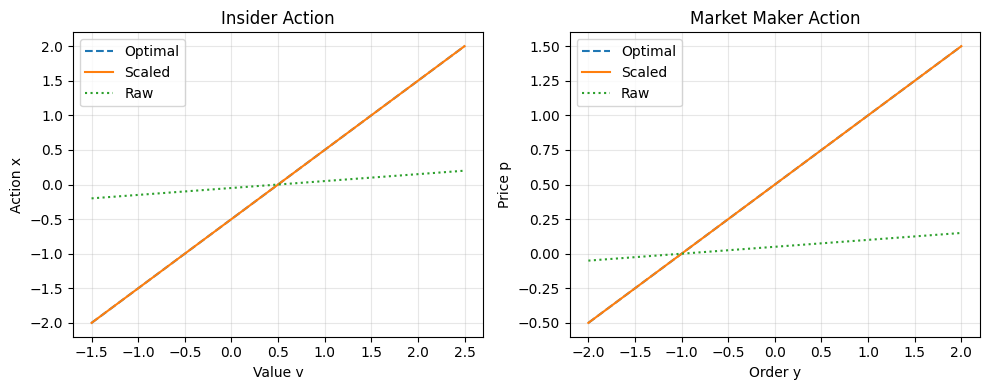

In [129]:
models = {}
models["insider"] = OptimalInsider()
models["market_maker"] = OptimalMM()

env = KyleOnePeriodAEC(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1)

evaluate_agents(models, env, 2)

train against a fixed MM

Starting training on KyleOnePeriodParallel with 2 agents.
=== Training loop 1/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


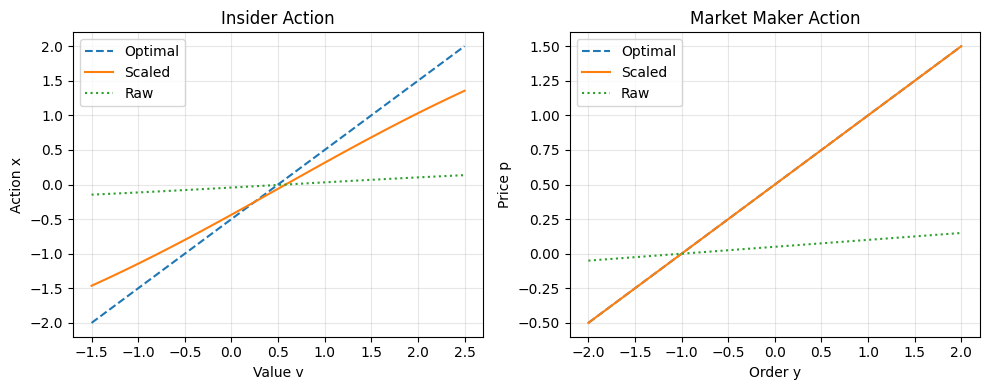

=== Training loop 2/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


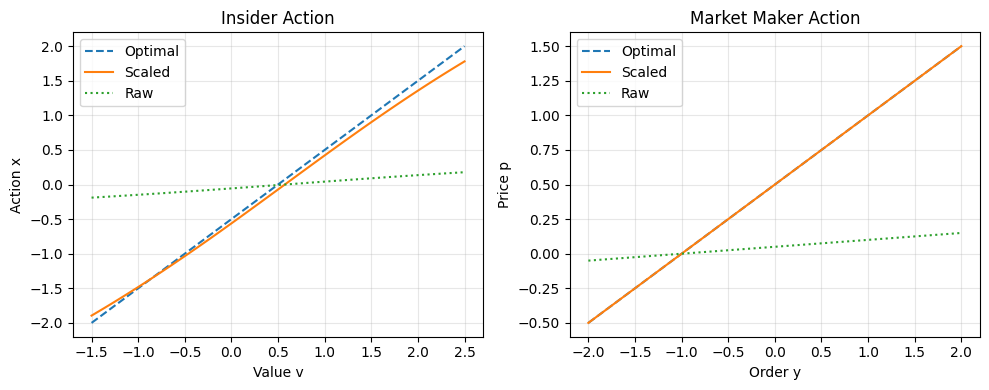

=== Training loop 3/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


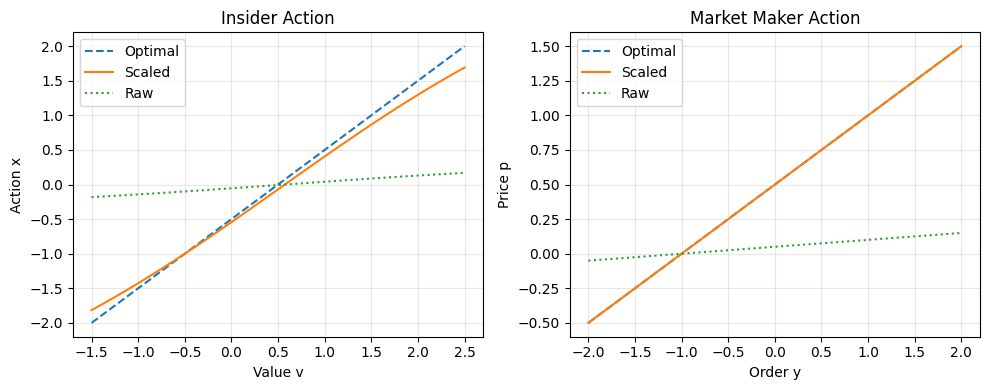

=== Training loop 4/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


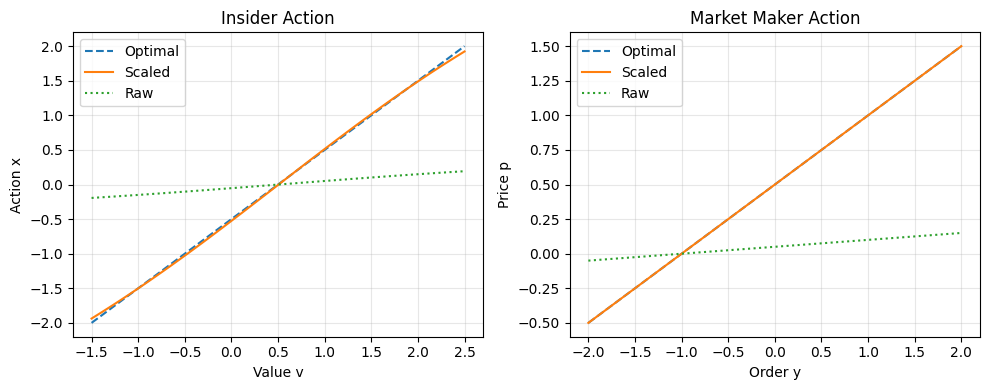

=== Training loop 5/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


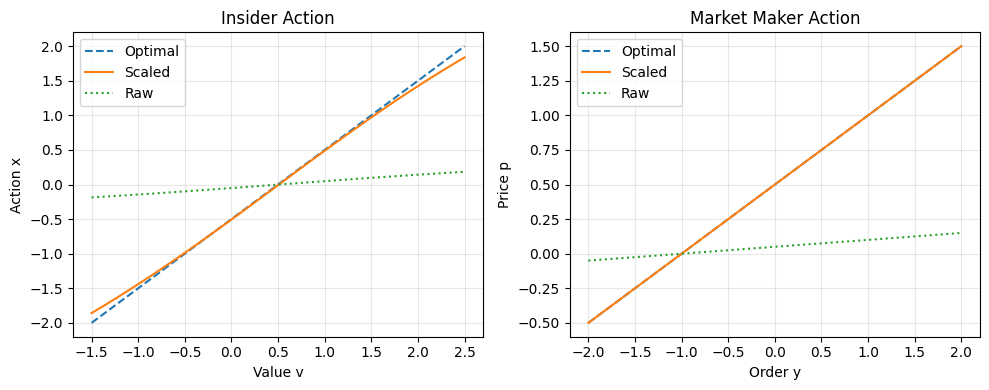

=== Training loop 6/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


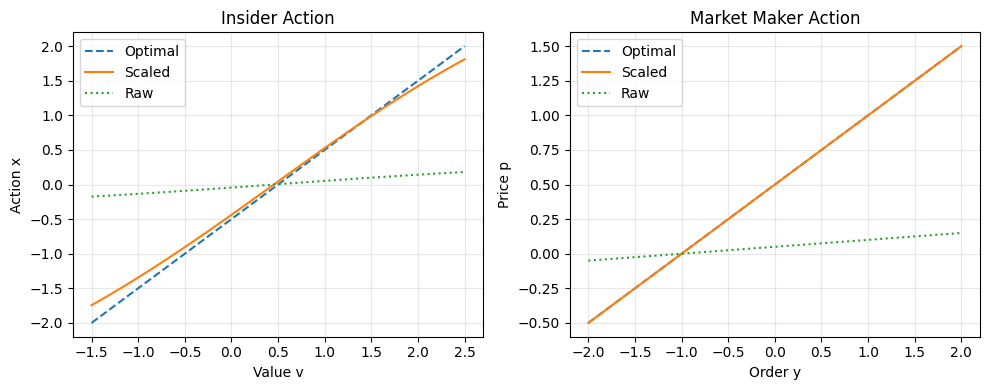

=== Training loop 7/10 ===
Training model for insider
Training model for market_maker
OptimalMM: fixed, no learning


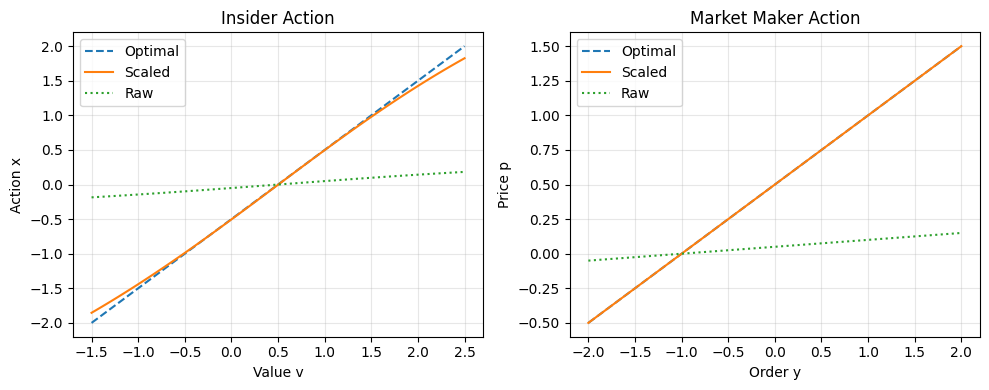

=== Training loop 8/10 ===
Training model for insider


KeyboardInterrupt: 

In [168]:

env_fn = KyleOnePeriodAEC
env_kwargs = dict(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1)

# Train a separate model for each agent
models = train_multi_agent(env_fn, steps=1024, loops=10, n_envs=1, seed=0, insider_fixed=False, mm_fixed=True, **env_kwargs)

## Key points for the implementation

Idea is:
- Environment: 
  - insider acts first (sees v, outputs x)
  - market maker acts second (sees y=x+u, outputs p)
  - rewards calculated for both agents only after both have acted
  - environment state tracks whose turn it is, stores intermediate actions, terminates after both have acted
- probably need to wrap AEC environment to work with two independent SB3 learners: (does supersuit do this?)
  - converts the env to single-agent view during training
  - ensures both learner and opponent act independently and in the right order
  - manages reward collection after both agents act (ie insider PPO gets insider reward) 
- training code:
  - separate PPOs per agent
  - coordinate training loops insider->MM->insider



## manual evals

In [46]:
insider_model = PPO.load("I2")
market_maker_model = PPO.load("MM2")

models = {
    "insider": insider_model,
    "market_maker": market_maker_model
}


In [57]:
env = KyleOnePeriodAEC(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1)
observations, infos = env.reset()

In [ ]:
eval_env = KyleOnePeriodAEC(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1)

evaluate_agents(models, env, 3)

Streaming output truncated to the last 5000 lines.
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36068832874298096
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3718290328979492
v value is 0.7638190954773871
Agent: market_maker, Action: 0.33802521228790283
v value is 0.7638190954773871
Agent: market_maker, Action: 0.38235533237457275
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36364632844924927
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3876854479312897
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3699757754802704
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3655184805393219
v value is 0.7638190954773871
Agent: market_maker, Action: 0.37164291739463806
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36300525069236755
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36692655086517334
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36268797516822815
v val

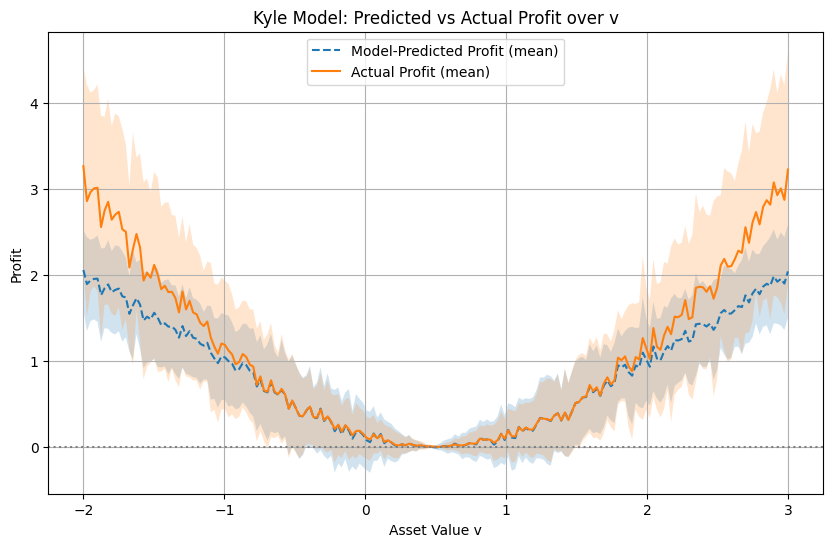

In [ ]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))
    agent1 = "insider"


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs = observations[agent]
        obs[0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u
            u = np.random.normal(0, env.sigma_u)
            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)

            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size
            action_unscaled = float(action[0])

            x = action_unscaled  # scale to actual action
            if v > -1 and v < 2:
                print(f"v value is {env.v}")
                print(f"Agent: {agent}, Action: {x}")
            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u
            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()